## Loads

In [1]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(root_dir)
os.chdir(root_dir)

In [2]:
os.getcwd()

'/home/helenajun/rag-llm-cancer-paper'

In [3]:
# !pip install rank_bm25
import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
from utils.evaluation import calc_eval_metrics, get_avg_eval_runs, plot_radar_chart
from utils.check_db_version import get_local_version
import colorcet as cc
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import math

_VERSION=get_local_version()
_VERSION

'2025-09-04'

## Real-world query characteristics

In [4]:
real_world_query=pd.read_csv("data/real_world_db/real_world_db_split__v1.csv", index_col=0)
real_world_query['cancer_type']=real_world_query['cancer_type'].apply(ast.literal_eval)
real_world_query.head()

,prompt,cancer_category,cancer_type,biomarker,dataset
0,what is the first-line treatment of metastatic...,GU,"[urothelial carcinoma, metastatic]",['fgfr3'],test
1,are parp inhibitors used for patients with lei...,Sarcoma,[leiomyosarcoma],"['dna', 'parp']",test
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,[rhabdomyosarcoma],"['alk', 'tfcp2']",validation
3,for a patient with cancer metastatic prostate ...,GU,"[prostate cancer, cancer]",['brca2'],test
4,for a patient with her2+ breast cancer after n...,Breast,"[breast cancer, disease]",['her2'],test


### Standardize cancer names

In [6]:
real_world_query['cancer_type'].value_counts().keys()

Index([                                                                                                  [],
                                                                                          ['breast cancer'],
                                                                                         ['bladder cancer'],
                                                                                          ['neuroblastoma'],
                                                                                        ['prostate cancer'],
                                                                                      ['colorectal cancer'],
                                                                     ['urothelial carcinoma', 'metastatic'],
                                                                                     ['cholangiocarcinoma'],
                                                                         ['muscle-invasive bladder cancer'],
                   

In [44]:
cancer_mapping={
    'breast cancer':['breast cancer','lobular breast cancer','breast carcinoma'],
    'bladder cancer':['bladder cancer','urothelial carcinoma','muscle-invasive bladder cancer'],
    'neuroblastoma':['neuroblastoma','high-risk neuroblastoma'],
    'prostate cancer':['prostate cancer'],
    'colorectal cancer':['colorectal cancer','colo-rectal carcinoma','ascending colon adenocarcinoma','colon adenocarcinoma'],
    'cholangiocarcinoma':['cholangiocarcinoma','intrahepatic cholangiocarcinoma'],
    'lung cancer':['lung cancer','lung adenocarcinoma','non-small cell lung adenocarcinoma','non-small cell lung cancer','non small cell lung cancer'],
    'osteosarcoma':['osteosarcoma'],
    'thyroid cancer':['thyroid cancer','anaplastic thyroid cancer','medullary thyroid cancer'],
    'follicular lymphoma':['follicular lymphoma'],
    'hepatoblastoma':['hepatoblastoma'],
    'rhabdomyosarcoma':['rhabdomyosarcoma'],
    'nut midline carcinoma':['nut midline carcinoma'],
    'stomach cancer':['gastric adenocarcinoma','gastroesophageal junction adenocarcinoma'],
    'ovarian cancer':['high grade serious ovarian carcinoma'],
    'kidney cancer':['kidney cancer','clear-cell renal cell carcinoma tumor','clear-cell renal cell carcinoma','clear-cell kidney cancer'],
    'testicular cancer':['testicular cancer'],
    'biliary tract cancer':['biliary tract cancer'],
    'pancreatic cancer':['pancreatic cancer','pancreatic adenocarcinoma','pancreatic ductal adenocarcinoma'],
    'lymphoid neoplasms':['lymphoid neoplasms'],
    'desmoid tumors':['desmoid tumors'],
    'wilms tumor':['wilms tumor','high grade wilms tumor'],
    'peripheral nerve sheath tumor':['peripheral nerve sheath tumor'],
    'oligodendroglioma':['oligodendroglioma'],
    'melanoma':['melanoma'],
    'ewing sarcoma':['ewing sarcoma'],
    'acute myeloid leukemia':['acute myeloid leukemia'],
    'medulloblastoma':['medulloblastoma'],
    'leiomyosarcoma':['leiomyosarcoma'],
    'endometrial cancer':['endometrial carcinoma'],
    'b-cell acute lymphoblastic leukemia':['b-cell acute lymphoblastic leukemia','b-all'],
    'midline glioma':['midline glioma'],
    'anaplastic large cell lymphoma':['anaplastic large cell lymphoma']
}

In [40]:
real_world_query['standardized_cancer_type']=None
for k, v in cancer_mapping.items():
    for idx, c in enumerate(real_world_query['cancer_type']):
        if set(c).intersection(set(v)):
            real_world_query.at[idx, 'standardized_cancer_type']=k

In [43]:
for idx, row in real_world_query[real_world_query['standardized_cancer_type'].isna()].iterrows():
    print(row['prompt'])

for patients with advanced cancer and with ntrk fusions, regardless of cancer types, are there drugs approved?
for patients with advanced cancer and with high tmb, regardless of cancer types, are there drugs approved?
is there an optimal drug combination to minimize the risk of post hsct relapse in a 2 year old with kmt2a rearranged aml?
i have a patient with stage iii nsclc with an l858r mutation who was treated with chemoradiation and had a partial radiographic response. what are adjuvant therapy options? if there are multiple, what is the preferred option?
my metastatic cutaneous melanoma patient has high tmb and a braf mutation. what should i do?
i have a patient with radioactive iodine referactory thyroid cancer. what is the first line option?
for a patient with relapsed b-all that expresses cd22, what antibody-drug conjugates may be used?
for a patient with relapsed b-all that expresses cd19, what targeted treatment options exist?
what targeted treatment options exist for patient

In [ ]:
ner_missed_cancer=['unspecified',
 'unspecified',
 'acute myeloid leukemia',
 'lung cancer',
 'melanoma',
 'thyroid cancer',
 'b-cell acute lymphoblastic leukemia',
 'b-cell acute lymphoblastic leukemia',
 'acute myeloid leukemia',
 'midline glioma',
 'acute myeloid leukemia',
 'acute myeloid leukemia',
 'chronic lymphocytic leukemia',
 'unspecified',
 'colorectal cancer',
 'colorectal cancer',
 'cholangiocarcinoma',
 'anaplastic large cell lymphoma'
 ]

len(ner_missed_cancer)

In [59]:
ner_missed_idx=real_world_query[real_world_query['standardized_cancer_type'].isna()].index
real_world_query.loc[ner_missed_idx, "standardized_cancer_type"]=ner_missed_cancer

### Number of biomarkers

In [ ]:
unique_biomarkers=real_world_query['biomarker'].drop_duplicates()
unique_biomarkers_ls=[]
for biomarker in unique_biomarkers:
    biomarkers=ast.literal_eval(biomarker)
    for b in biomarkers:
        if b not in unique_biomarkers_ls:
            unique_biomarkers_ls.append(b)

In [ ]:
exclude=['ihc 1','nsclc','aml','fda','parp','dna','hormone','bcs']
syns={
    'er':['estrogen receptor'],
    'hr':['hormone receptor'],
    'braf v600e':['brafv600e'],
}

In [ ]:
biomarkers={k if b in v else b for k, v in syns.items() for b in unique_biomarkers_ls}
for i in exclude:
    biomarkers.remove(i)

### Visualize cancer categories and types

Cancer category: cancer type grouped by its organ or system

In [166]:
counts=real_world_query['cancer_category'].value_counts()

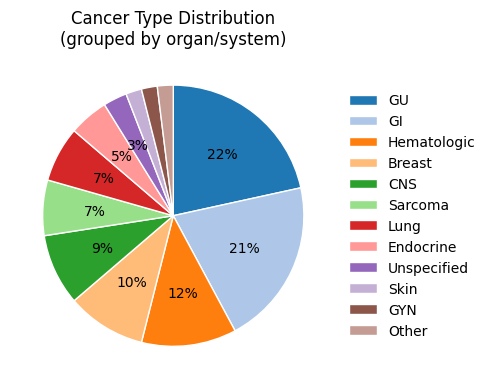

In [168]:
cols=sns.color_palette("tab20")
def autopct_func(pct):
    return f"{pct:.0f}%" if pct > 2 else ""  # only show if pct >= 3

fig, ax = plt.subplots(figsize=(5, 5))
wedges, _, autotexts = ax.pie(
    counts,
    autopct=autopct_func,
    startangle=90,
    counterclock=False,
    colors=cols,
    wedgeprops=dict(edgecolor='white')
)
for t in autotexts: 
    t.set_fontsize(10)
ax.legend(
    wedges, 
    counts.index, 
    # title='Cancer Type', 
    loc='center left', 
    bbox_to_anchor=(1,0.5),
    frameon=False
    )
plt.title("Cancer Type Distribution\n(grouped by organ/system)")
plt.tight_layout()
plt.show()

Cancer type: specific cancer types

In [148]:
counts=real_world_query['standardized_cancer_type'].value_counts()
n_unique=counts.keys().nunique()
n_unique

35

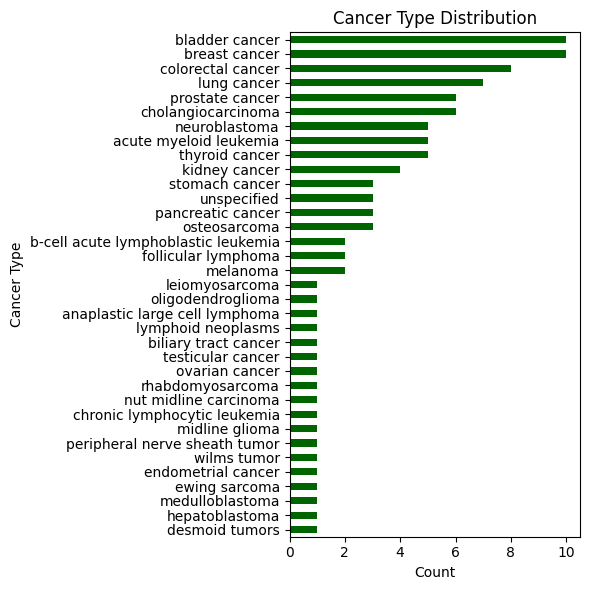

In [ ]:
counts[::-1].plot(
    kind="barh", 
    color="darkgreen",
    figsize=(6, 6)
    )
plt.xlabel("Count")
plt.ylabel("Cancer Type")
plt.title("Cancer Type Distribution")
plt.tight_layout()
plt.show()

In [181]:
real_world_query['dataset'].value_counts()

dataset
test          90
validation    12
Name: count, dtype: int64

## Real-world query validation

### Define metrics

In [5]:
# Define evaluation keys
METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

### Define evaluator

In [6]:
class Evaluator:
    def __init__(self, pipelines, strategies, metrics, query, true_dict, mode_paths, num_iter=1, subset_idx=None):
        """
        pipelines: list of pipelines ('RAG' for rag-llm or 'LLM' for llm-only)
        strategies: str (e.g., "0" for basic prompt or "5" for scope-defined prompt)
        mode_paths: dict of {mode_name: base_filepath}
        Example: {
            "dense": _DENSE_FILEPATH,
            "hybrid": _HYBRID_FILEPATH
        }
        """
        if isinstance(pipelines, str):
            pipelines = [pipelines]
            
        self.pipelines = pipelines
        self.strategies = strategies
        self.metrics = metrics
        self.true_dict = true_dict
        self.mode_paths = mode_paths
        self.num_iter = num_iter
        self.subset_idx = subset_idx
        
        # Subset queries if provided
        if self.subset_idx is not None:
            self.query = query.iloc[self.subset_idx]
        else:
            self.query = query
        
        # Initialize results for all pipelines and modes
        self.results = { 
            pipeline: {
                mode: {m: {s: [] for s in strategies} for m in metrics}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.evals = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.llm_input = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.llm_output = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.retrieval = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }

    def evaluate_strategy(self, pipeline, mode):
        base_path = self.mode_paths[mode]
        for s in self.strategies:
            filepath = os.path.join(base_path, f"{pipeline}stra{s}n{self.num_iter}temp0.0_res_dict.pkl")
            obj = load_object(filepath)
            
            for i in range(self.num_iter):
                try:
                    input_prompt = obj["input prompt"][i]
                    full_output = obj["full output"][i]
                    retrieval_output = obj["retrieval"][i]
                    
                    if self.subset_idx is not None:
                        input_prompt_subset = [input_prompt[j] for j in self.subset_idx]
                        full_output_subset = [full_output[j] for j in self.subset_idx]
                        retrieval_subset = [retrieval_output[j] for j in self.subset_idx]
                    else:
                        input_prompt_subset = input_prompt
                        full_output_subset = full_output
                        retrieval_subset = retrieval_output
                        
                    eval_dict = calc_eval_metrics(
                        full_output_subset,
                        self.query["prompt"].tolist(),
                        self.true_dict
                    )
                    self.evals[pipeline][mode][s].append(eval_dict)
                    self.llm_input[pipeline][mode][s].append(input_prompt_subset)
                    self.llm_output[pipeline][mode][s].append(full_output_subset)
                    self.retrieval[pipeline][mode][s].append(retrieval_subset)
                    for name, key in self.metrics.items():
                        self.results[pipeline][mode][name][s].append(eval_dict[key])
                except Exception:
                    continue

    def run(self):
        for pipeline in self.pipelines:
            for mode in self.mode_paths:
                self.evaluate_strategy(pipeline, mode)

    def average(self):
        average = {}
        for pipeline in self.pipelines:
            average[pipeline] = {}
            for mode in self.mode_paths:
                average[pipeline][mode] = {
                    m: {s: np.mean(vals) if vals else None for s, vals in strat.items()}
                    for m, strat in self.results[pipeline][mode].items()
                }
        return average


### Define compare modes functions

In [7]:
def compare_mode_A_vs_B(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = 0, 0, 0, 0
    
    for A_fail, B_fail in zip(A_failed, B_failed):
        if A_fail and B_fail:
            both_failed += 1
        elif A_fail and not B_fail:
            A_failed_B_success += 1
        elif not A_fail and B_fail:
            A_success_B_failed += 1
        else:
            both_success += 1
    return [both_success, A_success_B_failed,
            A_failed_B_success, both_failed]

def compare_mode_A_vs_B_idx(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = [], [], [], []
    for i, (A_fail, B_fail) in enumerate(zip(A_failed, B_failed)):
        if A_fail and B_fail:
            both_failed.append(i)
        elif A_fail and not B_fail:
            A_failed_B_success.append(i)
        elif not A_fail and B_fail:
            A_success_B_failed.append(i)
        else:
            both_success.append(i)
    return {
        "both_success": both_success,
        "both_failed": both_failed,
        "A_failed_B_success": A_failed_B_success,
        "A_success_B_failed": A_success_B_failed
    }

### Dense vs. Hybrid

In [55]:
num_iter = 5
strategies = ["5"]
_PIPELINE='RAG'
_DENSE_FILEPATH = 'output/RAG_res_gpt4o_default/structured_realworld_val_v2_dense'
_HYBRID_FILEPATH = 'output/RAG_res_gpt4o_default/structured_realworld_val_v2_hybrid'
_QUERY_VAL = pd.read_csv(f"data/real_world_db/real_world_validation__v2.csv", index_col=0)
_QUERY_TRUE = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "dense": _DENSE_FILEPATH,
    "hybrid": _HYBRID_FILEPATH
}

evaluator_val_queries = Evaluator(
    pipelines=_PIPELINE,
    strategies=strategies,
    metrics=METRICS,
    query=_QUERY_VAL,
    true_dict=_QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter
)

evaluator_val_queries.run()
average = evaluator_val_queries.average()

val_queries_results=evaluator_val_queries.results['RAG']
val_queries_average=average['RAG']
val_queries_average

{'dense': {'exact': {'5': 0.838095238095238},
  'partial': {'5': 0.980952380952381},
  'precision': {'5': 0.9333333333333332},
  'recall': {'5': 0.8106060606060606},
  'f1': {'5': 0.8454545454545453},
  'specificity': {'5': 0.9994834710743803}},
 'hybrid': {'exact': {'5': 0.8095238095238095},
  'partial': {'5': 0.9523809523809523},
  'precision': {'5': 0.8863636363636364},
  'recall': {'5': 0.7742424242424242},
  'f1': {'5': 0.8060606060606063},
  'specificity': {'5': 0.9994834710743803}}}

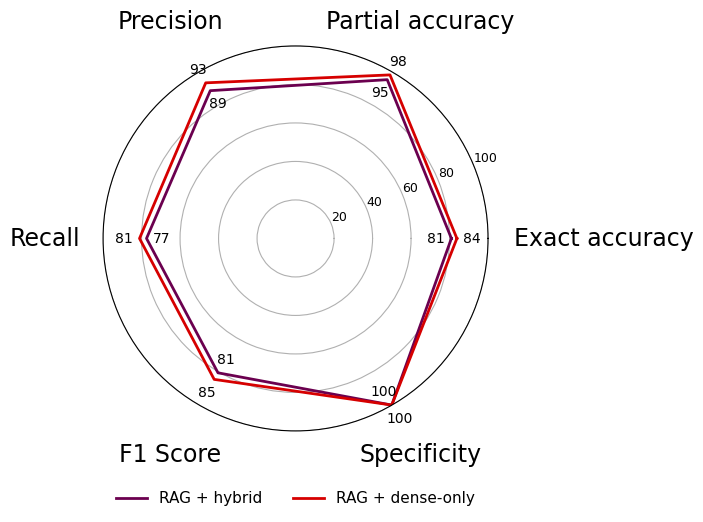

In [56]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'RAG + hybrid': {k: v['5']*100 for k, v in val_queries_average['hybrid'].items()},
    'RAG + dense-only': {k: v['5']*100 for k, v in val_queries_average['dense'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0]]
    )

Analyze failures:
- Are errors due to retrieval (recall of relevant contexts), reasoning (does the LLM use the retrieved info correctly?), or both?

Categorize errors:
- Retrieval failure (missing context)
- Misinterpretation (LLM misuses retrieved evidence)
- Hallucination/misattribution (LLM generates unsupported facts)

#### Partial match error analysis results



In [57]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))
print(all_results_idx)

[{'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'both_failed': [], 'A_failed_B_success': [], 'A_success_B_failed': [7]}, {'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'both_failed': [], 'A_failed_B_success': [], 'A_success_B_failed': [7]}, {'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'both_failed': [], 'A_failed_B_success': [], 'A_success_B_failed': [7]}, {'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'both_failed': [7], 'A_failed_B_success': [], 'A_success_B_failed': []}, {'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'both_failed': [7], 'A_failed_B_success': [], 'A_success_B_failed': []}]


In [58]:
all_runs=[all_results_idx[i]['both_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

7    2
Name: count, dtype: int64

In [59]:
all_runs=[all_results_idx[i]['A_failed_B_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

Series([], Name: count, dtype: int64)

In [60]:
all_runs=[all_results_idx[i]['A_success_B_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

7    3
Name: count, dtype: int64

In [45]:
for i in range(5):
    idx=all_results_idx[i]['A_success_B_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {evaluator_val_queries.query['prompt'][j]}")
        print("============= ground-truth =============")
        print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= dense =============")
        print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        print(evaluator_val_queries.llm_output['RAG']['dense']['5'][i][j])
        print(evaluator_val_queries.llm_input['RAG']['dense']['5'][i][j])
        print("============= hybrid =============")
        print(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_val_queries.llm_output['RAG']['hybrid']['5'][i][j])
        print(evaluator_val_queries.llm_input['RAG']['hybrid']['5'][i][j])
        print(evaluator_val_queries.retrieval['RAG']['hybrid']['5'][i][j]['retrieval_results'][0]['retrieved_df'])

============= query =============
(0, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'larotrectinib'}), frozenset({'entrectinib'}), frozenset({'repotrectinib'})}
============= dense =============
{frozenset({'larotrectinib'}), frozenset({'entrectinib'}), frozenset({'repotrectinib'})}
{
    "Status": "success",
    "Treatment 1": {
        "Disease Name": "Pancreatic Ductal Adenocarcinoma",
        "Disease Phase or Condition": "Stage IV",
        "Drug Name": "Repotrectinib",
        "Prior Treatment or Resistance Status": "Progressed following treatment or have no satisfactory alternative therapy",
        "Genomic Features": "NTRK gene fusion",
        "FDA-approval status": "Approved under accelerated approval based on overall response rate and duration of response",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/2

Inspect why hybrid failed question 19

In [11]:
def extract_retrieved_context(text):
    start_idx=text.find("[")
    end_idx=text.find("]")+1
    list_str=text[start_idx:end_idx]
    context_list=ast.literal_eval(list_str)
    return(context_list)

In [ ]:
#dense
extract_retrieved_context(evaluator_val_queries.llm_input['RAG']['dense']['5'][0][19])[0:5]

In [ ]:
#hybrid
evaluator_val_queries.retrieval['RAG']['hybrid']['5'][0][19]['retrieval_results'][0]['retrieved_df'][0:5]

Both failed:
- 7 (1/5) (what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation) \
    : context retrieved, LLM answer incorrect -> hybrid gets it right, but not always -> there's a difference between ntrk mutation and ntrk fusion -> context explicitly says it's fusion but the query is not explicit enough

Dense failed Hybrid success:
- 7 (1/5)

Dense success hybrid failed:
- 7 (1/5)
- 19 (3/5) (i have a patient with metastatic hr-negative, her2-low, pd-l1-negative, breast cancer with no germline brca mutation.  for second line, is t-dxd or sacituzumab govitecan preferred?) \
    : context retrieved -> 
        1) LLM misinterpretation due to context order (some lung contexts are on the top)?
        2) is this a rare case where hr-positive drug is used for hr-negative case?

Takeaway:
- But both worked quite well in getting at least one drug correct (partial match acc) on the real-world validation queries. There is one unusual case where the query query asks for hr-negative breast cancer case but the ground-truth drug is approved for hr-positive cases.
- It's also hard to conclude because most queries does not have FDA-approved drugs.


#### Exact match error analysis results

In [68]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['dense']['5'][i]['exact_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['exact_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))

In [62]:
all_runs=[all_results_idx[i]['both_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

3     5
17    5
18    5
7     2
Name: count, dtype: int64

In [63]:
all_runs=[all_results_idx[i]['A_failed_B_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

Series([], Name: count, dtype: int64)

In [64]:
all_runs=[all_results_idx[i]['A_success_B_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

7    3
Name: count, dtype: int64

In [67]:
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        if j == 17:
            print("============= query =============")
            print(f"{i,  j}: {evaluator_val_queries.query['prompt'][j]}")
            print("============= ground-truth =============")
            print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
            print("============= dense =============")
            print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
            # print(evaluator_val_queries.llm_output['RAG']['dense']['5'][i][j])
            print(evaluator_val_queries.llm_input['RAG']['dense']['5'][i][j])
            print("============= hybrid =============")
            print(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
            # print(evaluator_val_queries.llm_output['RAG']['hybrid']['5'][i][j])
            print(evaluator_val_queries.llm_input['RAG']['hybrid']['5'][i][j])
            # print(evaluator_val_queries.retrieval['RAG']['hybrid']['5'][i][j]['retrieval_results'][0]['retrieved_df'])
    break

============= query =============
(0, 17): i have a patient with de novo metastatic hr+ breast cancer with both a somatic akt mutation and a germline brca2 mutation - what are the standard, recommended first- and second-line treatments for this patient?
============= ground-truth =============
{frozenset({'fulvestrant', 'capivasertib'}), frozenset({'olaparib'}), frozenset({'talazoparib'})}
============= dense =============
{frozenset({'fulvestrant', 'capivasertib'}), frozenset({'olaparib'})}

    Context information is below.
    ---------------------
    ['if a patient with metastatic invasive breast carcinoma has her2-negative, brca1 pathogenic variants, one recommended therapy is olaparib. therapy type: targeted therapy. therapy strategy: parp inhibition. indication: lynparza is a poly (adp-ribose) polymerase (parp) inhibitor indicated for the treatment of adult patients with deleterious or suspected deleterious gbrcam, her2-negative metastatic breast cancer who have been treated wi

In [ ]:
extract_retrieved_context(evaluator_val_queries.llm_input['RAG']['dense']['5'][0][7])

In [ ]:
evaluator_val_queries.retrieval['RAG']['hybrid']['5'][0][3]

Both failed:
- 3 (5/5) (for a patient with cancer metastatic prostate cancer, advanced stage (most often stage iv, but some stage iii or earlier potentially) and with brca2 mutation, what drugs approved?) \
    : context retrieved incomplete -> missing prednisolone + abiraterone acetate + *niraparib* (probably due to the fact that there are many biomarker-linked drugs approved for prostate cancer) -> this is mainly due to an error in the database (missing BRCA-linked relationship for prednisolone + abiraterone acetate + niraparib) -> Brendan will update the db
- 17 (5/5) (i have a patient with de novo metastatic hr+ breast cancer with both a somatic akt mutation and a germline brca2 mutation - what are the standard, recommended first- and second-line treatments for this patient?) \
    : context retrieved -> llm failed to retrieve *talazoparib*, which was in the lower part of the context list
    -> after adding fuzzy matching *talazoparib* is now on the top part of the list but the llm is still misinterpreting, why?
- 18 (5/5) (i have a patient with an initial diagnosis of ct3n1 her2+ breast cancer who received neoadjuvant tchp and had 1cm of residual disease at surgery. what is the recommended adjuvant treatment for this patient and what are the clinical trials that i should consider?) \
    : context mostly retrieved (hybrid context retrieved better than dense in terms of order of relevant contexts) -> LLM recall failure, retrieved trastuzumab emtansine only, probably because of query specificity (query: "neoadjuvant TCHP" -> kadcyla or trastuzumab emtansine: "...after neoadjuvant ... treatment"), heavily biasing llm's retrieval toward trastuzumab emtansine. it failed to generalize to other related therapies like neratinib, trastuzumab deruxtecan, and trastuzumab + pertuzumab
- 7 (1/5) -> for this i tried increasing temperature to 0.2, which then LLM retrieved these drugs

Dense failed hybrid success:
- 7 (1/5)

Dense success hybrid failed:
- 7 (1/5), 19 (4/5)

Key Takeaways:
- Both dense and hybrid methods performed quite well in terms of partial recall (partial match acc)
- Dense outperformed hybrid in query 19 with with HER2-low, HR-negative breast cancer, which is an edge case 

## Real-world query evaluation

### Define evaluation metrics

In [50]:
# Define evaluation keys
METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

### Dense-only vs. Hybrid

In [52]:
num_iter = 5
strategies = ["5"]
DENSE_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_dense'
HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_hybrid'
QUERY_TEST = pd.read_csv(f"data/real_world_db/real_world_test__v2.csv", index_col=0)
QUERY_TRUE = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "dense": DENSE_FILEPATH,
    "hybrid": HYBRID_FILEPATH
}

evaluator_all_queries = Evaluator(
    pipelines=['RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=QUERY_TEST,
    true_dict=QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter
)

evaluator_all_queries.run()
average = evaluator_all_queries.average()

all_queries_results=evaluator_all_queries.results['RAG']
all_queries_average=average['RAG']

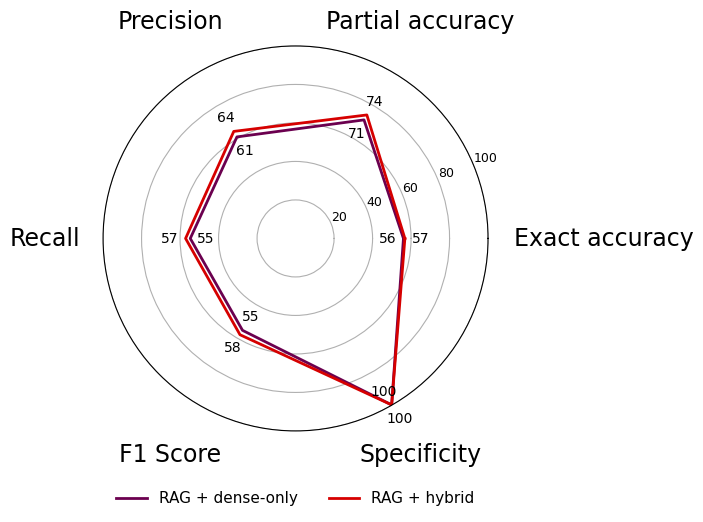

In [54]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'RAG + dense-only': {k: v['5']*100 for k, v in all_queries_average['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in all_queries_average['hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0]]
    )

### Group queries
- All vs. Queries within scope (asking biomarker-associated, FDA approved drugs)
- Including single biomarker vs. multiple biomarkers vs. biomarkers with unknown significance
- Queries within scope vs. tumor-agnostic queries

In [113]:
QUERY_RAW=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers__v1.csv")
QUERY_RAW=QUERY_RAW.dropna(subset='Questions').reset_index(drop=True)

query_in_scope=QUERY_RAW[
    (QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (QUERY_RAW['Asking_therapy']==True)
    ].index.tolist()

query_multiple_biomarkers=QUERY_RAW[
    (QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (QUERY_RAW['Asking_therapy']==True) &
    (QUERY_RAW['Multiple_biomarkers']==True)
    ].index.tolist()

In [114]:
# add boolean columns to group queries
QUERY_TEST.loc[QUERY_TEST.index.isin(query_in_scope), 'within_scope']=True
QUERY_TEST.loc[QUERY_TEST.index.isin(query_multiple_biomarkers), 'multiple_biomarkers']=True

#### All queries (n=90) vs. Queries within scope (n=83)

In [115]:
# get appropriate indices
QUERY_TEST_REINDEXED=QUERY_TEST.reset_index()
within_scope_ind=QUERY_TEST_REINDEXED[
    QUERY_TEST_REINDEXED['index']
    .isin(QUERY_TEST[QUERY_TEST['within_scope']==True].index)
    ].index.tolist()

In [124]:
num_iter = 5
strategies = ["5"]

mode_paths = {
    "dense": DENSE_FILEPATH,
    "hybrid": HYBRID_FILEPATH
}

evaluator_within_scope_queries = Evaluator(
    pipelines=['RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=QUERY_TEST_REINDEXED,
    true_dict=QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter,
    subset_idx=within_scope_ind
)
evaluator_within_scope_queries.run()
average = evaluator_within_scope_queries.average()
within_scope_queries_results=evaluator_within_scope_queries.results['RAG']
within_scope_queries_average=average['RAG']

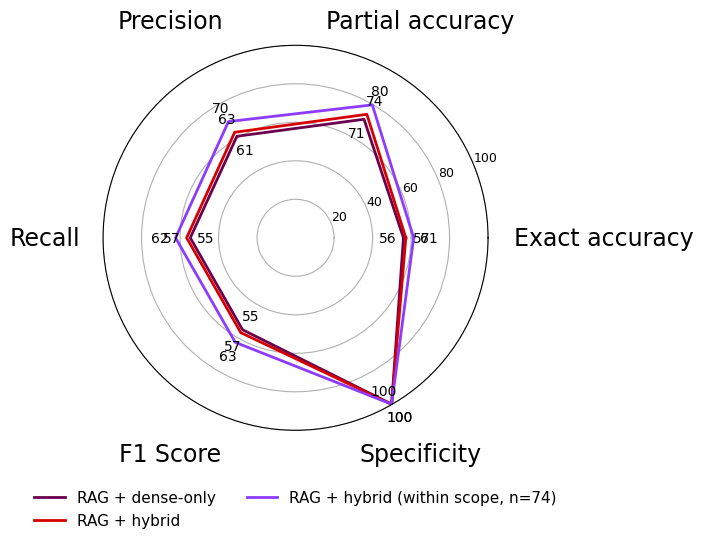

In [ ]:
cols=sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

n = QUERY_TEST_REINDEXED.loc[within_scope_ind].shape[0]
plot_results = {
    'RAG + dense-only': {k: v['5']*100 for k, v in all_queries_average['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in all_queries_average['hybrid'].items()},
    f'RAG + hybrid (within scope, {n=})': {k: v['5']*100 for k, v in within_scope_queries_average['hybrid'].items()}
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0],cols[1]]
    )

### Inspect success and failed cases in dense-only search vs. hybrid search

In [127]:
QUERY_SCOPE=QUERY_TEST_REINDEXED.loc[within_scope_ind]
QUERY_SCOPE.reset_index(inplace=True)
QUERY_SCOPE.rename(columns={'level_0':'test_query_index','index':'all_query_index'}, inplace=True)

In [128]:
all_results = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results.append(compare_mode_A_vs_B(dense_partial_failed, hybrid_partial_failed))

arr = np.array(all_results)

summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Dense Success and Hybrid Failed": arr[:,1],
    "Dense Failed and Hybrid Success": arr[:,2],
    "Both Failed": arr[:,3]
})

summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)


                                 mean       std
Both Success                     56.0  0.707107
Dense Success and Hybrid Failed   0.6  0.894427
Dense Failed and Hybrid Success   3.0  0.707107
Both Failed                      14.4  1.140175


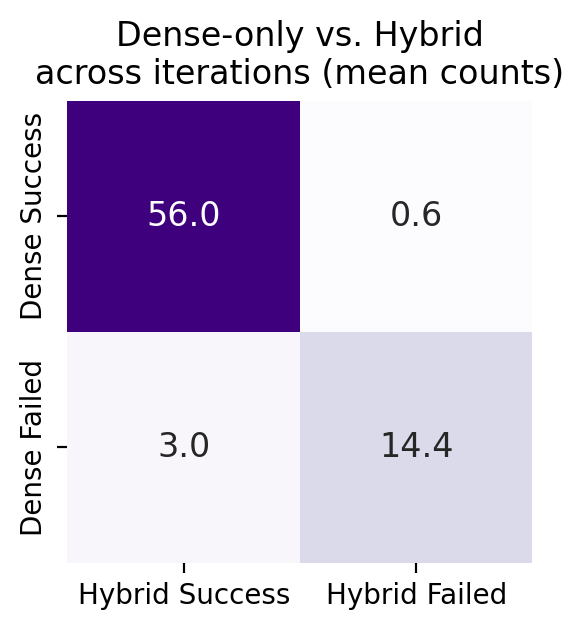

In [129]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

avg_cm = np.array([
    [summary_stats.loc["Both Success","mean"], summary_stats.loc["Dense Success and Hybrid Failed","mean"]],
    [summary_stats.loc["Dense Failed and Hybrid Success","mean"], summary_stats.loc["Both Failed","mean"]]
])
sns.heatmap(avg_cm, annot=True, annot_kws={"fontsize": 12},
            fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=["Hybrid Success", "Hybrid Failed"],
            yticklabels=["Dense Success", "Dense Failed"])
plt.title("Dense-only vs. Hybrid\nacross iterations (mean counts)")
plt.show()

In [140]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))

In [141]:
all_runs=[all_results_idx[i]['both_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

11    5
13    5
19    5
23    5
26    5
35    5
37    5
41    5
50    5
52    5
53    5
57    5
61    5
45    4
20    2
54    1
Name: count, dtype: int64

In [248]:
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        print(j)
        print("============= dense =============")
        print(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        print("============= hybrid =============")
        print(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        print("============= ground-truth =============")
        print(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
    break

11
============= dense =============
{frozenset({'pembrolizumab'})}
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'cabozantinib', 'nivolumab'}), frozenset({'pembrolizumab', 'lenvatinib'}), frozenset({'ipilimumab', 'nivolumab'}), frozenset({'axitinib', 'avelumab'}), frozenset({'axitinib', 'pembrolizumab'})}
13
============= dense =============
{frozenset({'erdafitinib'})}
============= hybrid =============
{frozenset({'erdafitinib'})}
============= ground-truth =============
{frozenset({'enfortumab vedotin'})}
19
============= dense =============
set()
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'cabozantinib'})}
23
============= dense =============
set()
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'doxorubicin'}), frozenset({'cisplatin'}), frozenset({'methotrexate'})}
26
============= dense =============
{frozenset({'midostaurin', 'cytarabi

Drug indication not linked to a biomarker: 19, 23 

In [238]:
all_results = []
for i in range(5): 
    dense_exact_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['exact_match_acc'])
    hybrid_exact_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['exact_match_acc'])
    all_results.append(compare_mode_A_vs_B(dense_exact_failed, hybrid_exact_failed))

arr = np.array(all_results)

summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Dense Success and Hybrid Failed": arr[:,1],
    "Dense Failed and Hybrid Success": arr[:,2],
    "Both Failed": arr[:,3]
})

summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)


                                 mean       std
Both Success                     43.6  0.547723
Dense Success and Hybrid Failed   0.8  0.836660
Dense Failed and Hybrid Success   1.8  0.447214
Both Failed                      27.8  1.095445


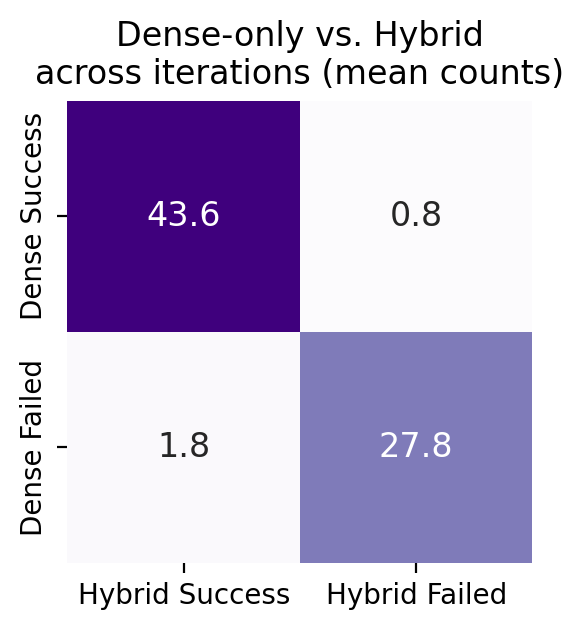

In [239]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

avg_cm = np.array([
    [summary_stats.loc["Both Success","mean"], summary_stats.loc["Dense Success and Hybrid Failed","mean"]],
    [summary_stats.loc["Dense Failed and Hybrid Success","mean"], summary_stats.loc["Both Failed","mean"]]
])
sns.heatmap(avg_cm, annot=True, annot_kws={"fontsize": 12},
            fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=["Hybrid Success", "Hybrid Failed"],
            yticklabels=["Dense Success", "Dense Failed"])
plt.title("Dense-only vs. Hybrid\nacross iterations (mean counts)")
plt.show()

### Edge cases or rare cases analysis